## 图像数据处理

In [321]:
import os
import numpy as np
import cv2

In [322]:
def get_img_list(dirname,flag=0):  # 读取文件列表
    rootdir = os.path.abspath('./data/' + dirname + '/')
    list = os.listdir(rootdir)  # 列出文件夹下所有的目录与文件
    files = []
    for i in range(0, len(list)):
        path = os.path.join(rootdir, list[i])
        if os.path.isfile(path):
            files.append(path)
    return files

In [323]:
def read_img(list, flag=0):  # 读取图片为数据
    for i in range(len(list) - 1):
        if os.path.isfile(list[i]):
            images.append(cv2.imread(list[i]).flatten())
            labels.append(flag)

In [324]:
images = []
labels = []

# 读取图像数据并做标记
read_img(get_img_list('male'), [0, 1])
read_img(get_img_list('female'), [1, 0])

# 转换数组
images = np.array(images)
labels = np.array(labels)

In [325]:
len(images),len(labels),images.shape,labels.shape

(397, 397, (397, 30912), (397, 2))

In [326]:
images[0],labels[0]

(array([ 84,  84,  84, ..., 228, 228, 228], dtype=uint8), array([0, 1]))

In [327]:
# np.random.permutation(index)对指定范围的序列进行随机排序
per = np.random.permutation(labels.shape[0])
# 重新排序
all_images = images[per,:]
all_labels = labels[per,:]

In [328]:
# 拆分测试集与训练集，2:8
images_total = all_images.shape[0]
# 切片索引需整数
train_num = int(images_total*0.8)
test_num = images_total-train_num

images_train = all_images[0:train_num,:].astype("float32") / 255
labels_train = all_labels[0:train_num,:].astype("float32")
images_test = all_images[train_num:images_total,:].astype("float32") / 255
labels_test = all_labels[train_num:images_total,:].astype("float32")

In [329]:
images_train.shape,labels_train.shape

((317, 30912), (317, 2))

## 构建定义模型

In [330]:
np.set_printoptions(suppress=True)  # 设置小数不以科学计数法输出

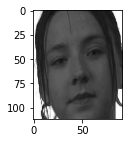

(array([[1., 0.]], dtype=float32),
 array([[0.9607843 , 0.9607843 , 0.9607843 , ..., 1.        , 1.        ,
         1.        ],
        [0.23529412, 0.23529412, 0.23529412, ..., 0.93333334, 0.93333334,
         0.93333334],
        [0.5137255 , 0.5137255 , 0.5137255 , ..., 0.13333334, 0.13333334,
         0.13333334],
        ...,
        [0.10196079, 0.10196079, 0.10196079, ..., 0.07450981, 0.07450981,
         0.07450981],
        [0.9843137 , 0.9843137 , 0.9843137 , ..., 0.7411765 , 0.7411765 ,
         0.7411765 ],
        [0.21568628, 0.21568628, 0.21568628, ..., 0.22352941, 0.22352941,
         0.22352941]], dtype=float32),
 (1, 30912))

In [331]:
import matplotlib.pyplot as plt
# 绘制一张图像
input_images = images_train[0:1] 
input_labels = labels_train[0:1]
fig,ax = plt.subplots(figsize=(2,2))
ax.imshow(np.reshape(input_images,(112,92,3)))
plt.show()
input_labels,images_train,input_images.shape

In [332]:
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix, classification_report

In [333]:

# 训练参数
train_epochs = 200
drop_out = 0.7
learning_rate = 0.0000056

def weight_init(shape):
    # 截断的产生正态分布的随机数，即随机数与均值的差值若大于两倍的标准差，则重新生成。
    weight = tf.truncated_normal(shape,stddev=0.1,dtype=tf.float32)
    return tf.Variable(weight)
def bias_init(shape):
    bias = tf.random_normal(shape,dtype=tf.float32)
    return tf.Variable(bias)

"""
输入占位
    input_images: [None,112*92*3]
    input_labels: [None,2]
"""
images_input = tf.placeholder(tf.float32,[None,images_train.shape[1]],
                              name = "images_input")
labels_input = tf.placeholder(tf.float32,[None,labels_train.shape[1]],
                             name = "labels_input")
images_input

<tf.Tensor 'images_input_16:0' shape=(?, 30912) dtype=float32>

In [334]:
"""
input/out: [None,nH,nW,channels]
padding:
    VALID:不填充数据
    SAME:填充数据
"""
def conv2d(images,filter_input,lname):
    return tf.nn.conv2d(images,filter_input,strides=[1,1,1,1],
                        padding="SAME",name=lname)

def maxpooling2d(images,lname):
    return tf.nn.max_pool(images,ksize=[1,2,2,1],
                             strides=[1,2,2,1],padding="SAME")

In [335]:
x_input = tf.reshape(images_input,[-1,112,92,3])
# x_input,images_input

In [336]:
# 前向传播

# 第一层卷积  16个[3,3,3]卷积核
w1 = weight_init([3,3,3,16])
b1 = bias_init([16])
conv_1 = conv2d(x_input,w1,"conv_1")+b1
relu_1 = tf.nn.relu(conv_1)
max_pool_1 = maxpooling2d(relu_1,"max_pool_1")

# 第二层卷积 32个[3,3,3]卷积核
w2 = weight_init([3,3,16,32])
b2 = bias_init([32])
conv_2 = conv2d(max_pool_1,w2,"conv_2")+b2
relu_2 = tf.nn.relu(conv_2)
max_pool_2 = maxpooling2d(relu_2,"max_pool_2")

# 第三层卷积 64个[3,3,3]卷积核
w3 = weight_init([3,3,32,64])
b3 = bias_init([64])
conv_3 = conv2d(max_pool_2,w3,"conv_3")+b3
relu_3 = tf.nn.relu(conv_3)
max_pool_3 = maxpooling2d(relu_3,"max_pool_3")

# 展开

flatten = tf.reshape(max_pool_3,[-1,14*12*64])
max_pool_3

<tf.Tensor 'MaxPool_53:0' shape=(?, 14, 12, 64) dtype=float32>

In [337]:
# 第一层全连接
w4 = weight_init([14*12*64,512])
b4 = bias_init([512])
f1 = tf.matmul(flatten,w4)+b4
relu_f1 = tf.nn.relu(f1)
dropout_f1 = tf.nn.dropout(relu_f1,drop_out)

# 第二层全连接
w5 = weight_init([512,256])
b5 = bias_init([256])
f2 = tf.matmul(dropout_f1,w5)+b5
relu_f2 = tf.nn.relu(f2)
dropout_f2 = tf.nn.dropout(relu_f2,0.7)

# 第三层
w6 = weight_init([256,128])
b6 = bias_init([128])
f3 = tf.matmul(dropout_f2,w6)+b6
relu_f3 = tf.nn.relu(f3)
dropout_f3 = tf.nn.dropout(relu_f3,0.75)

# 第四层全连接，softmax输出
w7 = weight_init([128,2])
b7 = bias_init([2])
f4 = tf.matmul(dropout_f3,w7)+b7
softmax_f = tf.nn.softmax(f4,name="softmax_f")
# softmax_f = tf.sigmoid(f4,name="sigmoid_f")

In [338]:
# 反向传播
# 交叉熵损失函数
cross_entry = tf.reduce_mean(
    tf.reduce_sum(-input_labels*tf.log(softmax_f)))
binary_cross = tf.keras.losses.binary_crossentropy(input_labels,softmax_f)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(binary_cross)

In [339]:
#计算准确率
arg1 = tf.argmax(input_labels,-1)
arg2 = tf.argmax(softmax_f,-1)
cos = tf.equal(arg1,arg2)
acc = tf.reduce_mean(tf.cast(cos,dtype=tf.float32))

In [340]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
Cost = []
Accuracy = []
for i in range(train_epochs):
    batch_size = random.randint(200,300)
    batch_start = random.randint(0,len(images_train)-300)
    train_input = images_train[batch_start:(batch_start+batch_size)]
    train_labels = labels_train[batch_start:(batch_start+batch_size)]
    result,acc1,cross_entry_r,cos1,f_softmax1,relu_1_r= sess.run([optimizer,acc,cross_entry,cos,softmax_f,relu_1],feed_dict={images_input:train_input,labels_input:train_labels})
    print(f"第{i}轮，\tloss={cross_entry_r},\tacc={acc1}")
    Cost.append(cross_entry_r)
    Accuracy.append(acc1)

第0轮，	loss=897.1817626953125,	acc=0.7220077514648438
第1轮，	loss=nan,	acc=0.7808219194412231
第2轮，	loss=781.305419921875,	acc=0.7276264429092407
第3轮，	loss=638.805908203125,	acc=0.7792207598686218
第4轮，	loss=507.30902099609375,	acc=0.8355555534362793
第5轮，	loss=544.2821655273438,	acc=0.7772511839866638
第6轮，	loss=615.5455932617188,	acc=0.7991967797279358
第7轮，	loss=344.974609375,	acc=0.8169013857841492
第8轮，	loss=429.22735595703125,	acc=0.8655462265014648
第9轮，	loss=326.9242248535156,	acc=0.8545454740524292
第10轮，	loss=489.73345947265625,	acc=0.8149779438972473
第11轮，	loss=426.7086181640625,	acc=0.8488371968269348
第12轮，	loss=336.44854736328125,	acc=0.8796680569648743
第13轮，	loss=459.2320556640625,	acc=0.8550724387168884
第14轮，	loss=230.94094848632812,	acc=0.8497652411460876
第15轮，	loss=nan,	acc=0.8863636255264282
第16轮，	loss=184.56597900390625,	acc=0.9306930899620056
第17轮，	loss=379.20489501953125,	acc=0.8659793734550476
第18轮，	loss=nan,	acc=0.9079498052597046
第19轮，	loss=nan,	acc=0.8666666746139526
第20轮，

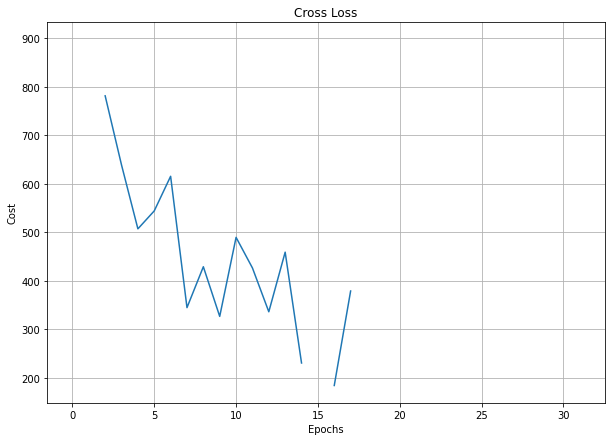

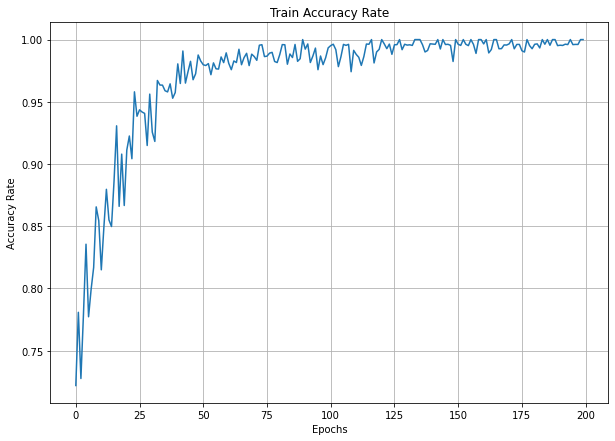

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0] [0]


ValueError: Found input variables with inconsistent numbers of samples: [1, 80]

In [341]:
# 代价函数曲线
fig1,ax1 = plt.subplots(figsize=(10,7))
plt.plot(Cost)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cost')
plt.title('Cross Loss')
plt.grid()
plt.show()

# 准确率曲线
fig7,ax7 = plt.subplots(figsize=(10,7))
plt.plot(Accuracy)
ax7.set_xlabel('Epochs')
ax7.set_ylabel('Accuracy Rate')
plt.title('Train Accuracy Rate')
plt.grid()
plt.show()


#测试
arg2_r = sess.run(arg2,feed_dict={images_input:images_test,labels_input:labelsa_test})
arg1_r = sess.run(arg1,feed_dict={images_input:images_test,labels_input:labelsa_test})
print(arg2_r,arg1_r)
print (classification_report(arg1_r, arg2_r))

#保存模型
saver = tf.train.Saver()
saver.save(sess, './model/my-gender-v1.0')